# Example on the usage of NIMBUS
This notebook will go through a simple example to illustrate how the synchronous variant of NIMBUS has been implemented in the DESDEO framework.

We will be solving the Kursawe function originally defined in [this article](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.47.8050&rep=rep1&type=pdf).

Let us begin by importing some libraries and defining the problem.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from desdeo_problem.Problem import MOProblem
from desdeo_problem.Variable import variable_builder
from desdeo_problem.Objective import _ScalarObjective

def f_1(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    xs_plusone = np.roll(xs, 1, axis=1)
    return np.sum(-10*np.exp(-0.2*np.sqrt(xs[:, :-1]**2 + xs_plusone[:, :-1]**2)), axis=1)

def f_2(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    return np.sum(np.abs(xs)**0.8 + 5*np.sin(xs**3), axis=1)


varsl = variable_builder(
    ["x_1", "x_2", "x_3"],
    initial_values=[0, 0, 0],
    lower_bounds=[-5, -5, -5],
    upper_bounds=[5, 5, 5],
)

f1 = _ScalarObjective(name="f1", evaluator=f_1)
f2 = _ScalarObjective(name="f2", evaluator=f_2)

problem = MOProblem(variables=varsl, objectives=[f1, f2], ideal=np.array([-20, -12]), nadir=np.array([-14, 0.5]))

To check out the problem, let us compute a representation of the Pareto optimal front of solutions:

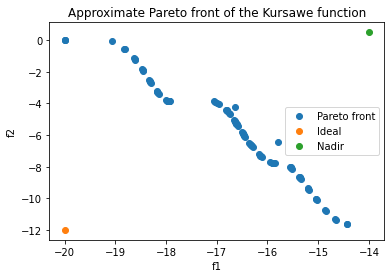

In [2]:
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation

p_front = solve_pareto_front_representation(problem, step=1.0)[1]

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Now we can get to the NIMBUS part. Let us define an instance of the NIMBUS method utilizing our problem defined earlier, and start by invoking the instance's `start` method:

In [3]:
from desdeo_mcdm.interactive.NIMBUS import NIMBUS

method = NIMBUS(problem, "scipy_de")

classification_request, plot_request = method.start()

C:\Users\Stefu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Stefu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1

Let us look at the keys in the dictionary contained in the `classification_request`:

In [4]:
print(classification_request.content.keys())

dict_keys(['message', 'objective_values', 'classifications', 'levels', 'number_of_solutions'])


Message should give us some more information:

In [5]:
print(classification_request.content["message"])

Please classify each of the objective values in one of the following categories:
	1. values should improve '<'
	2. values should improve until some desired aspiration level is reached '<='
	3. values with an acceptable level '='
	4. values which may be impaired until some upper bound is reached '>='
	5. values which are free to change '0'
Provide the aspiration levels and upper bounds as a vector. For categories 1, 3, and 5,the value in the vector at the objective's position is ignored. Suppy also the number of maximumsolutions to be generated.


We should therefore classify each of the objectives found behind the `objective_values` -key in the dictionary in `classification_request.content`. Let's print them:

In [6]:
print(classification_request.content["objective_values"])

[-15.88196134  -7.75152433]


Instead of printing the values, we could have also used the `plot_request` object. However, we are inspecting only one set of objective values for the time being, so a raw print of the values should be enough. Let us classify the objective values next. We can get a hint of what the classification should look like by inspecting the value found using the `classifications` -key in `classification_request.content`:

In [7]:
print(classification_request.content["classifications"])

[None]


Therefore it should be a list. Suppose we wish to improve (decrease in value) the first objective, and impair (increase in value) the second objective till some upper bound is reached. We should define our preferences as a dictionary `classification_request.response` with the keys `classifications` and `number_of_solutions` (we have to define the number of new solutions we wish to compute). The key `levels` will contain the upper bound for the second objective.

In [8]:
response = {
    "classifications": ["<", ">="],
    "number_of_solutions": 3,
    "levels": [0, -5]
}
classification_request.response = response

To continue, just feed `classification_request` back to the method through the `step` method:

In [9]:
save_request, plot_request = method.iterate(classification_request)

We got a new request as a response. Let us inspect it:

In [10]:
print(save_request.content.keys())
print(save_request.content["message"])
print(save_request.content["objectives"])

dict_keys(['message', 'solutions', 'objectives', 'indices'])
Please specify which solutions shown you would like to save for later viewing. Supply the indices of such solutions as a list, or supply an empty list if none of the shown soulutions should be saved.
[array([-16.66318205,  -5.00692627]), array([-2.00000000e+01,  5.82678381e-07]), array([-18.47502865,  -1.82301982])]


Suppose the first and last solutions result in nice objective values.

In [11]:
response = {"indices": [0, 2]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

In [12]:
print(intermediate_request.content.keys())
print(intermediate_request.content["message"])

dict_keys(['message', 'solutions', 'objectives', 'indices', 'number_of_desired_solutions'])
Would you like to see intermediate solutions between two previusly computed solutions? If so, please supply two indices corresponding to the solutions.


We do not desire to see intermediate results.

In [13]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

In [14]:
print(preferred_request.content.keys())
print(preferred_request.content["message"])

dict_keys(['message', 'solutions', 'objectives', 'index', 'continue'])
Please select your most preferred solution and whether you would like to continue. 


We should select our most preferred solution. Let us plot the objective values to inspect them better:

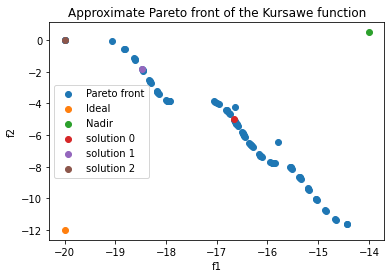

In [15]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Solutions at indices 0 and 2 seem to be overlapping in the objective space. We decide to select the solution at index 1, and to continue the iterations.

In [16]:
response = {"index": 1, "continue": True}
preferred_request.response = response

classification_request, plot_request = method.iterate(preferred_request)

Back at the classification phase of the NIMBUS method.

In [17]:
response = {
    "classifications": [">=", "<"],
    "number_of_solutions": 4,
    "levels": [-16, -1]
}
classification_request.response = response

save_request, plot_request = method.iterate(classification_request)

C:\Users\Stefu\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Let us plot some of the solutions again:

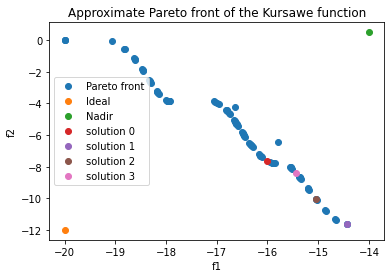

In [18]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

NIMBUS really took to heart our request to detoriate the first objective... Suppose we like all of the solutions:

In [19]:
response = {"indices": [0, 1, 2, 3]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

Let us plot everything we have so far:

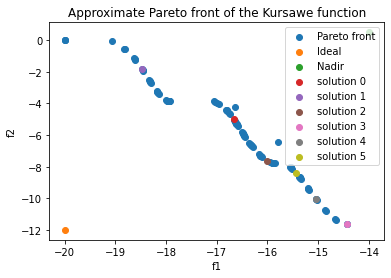

In [20]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(intermediate_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Assume we really like what we have between solutions 3 and 4. Let NIMBUS compute 3 intermediate solutions between them:

In [21]:
response = {
    "indices": [3, 4],
    "number_of_desired_solutions": 3,
    }
intermediate_request.response = response

save_request, plot_request = method.iterate(intermediate_request)

Plot the intermediate solutions:

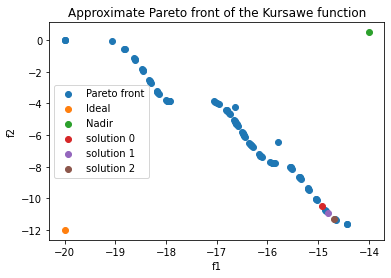

In [22]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Nice, we are really getting there, even if we have no goal set... Let us save solution 1:

In [23]:
response = {"indices": [1]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

We do not wish to generate any more intermediate solutions.

In [24]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

Let us plot everything we have, and select a final solution:

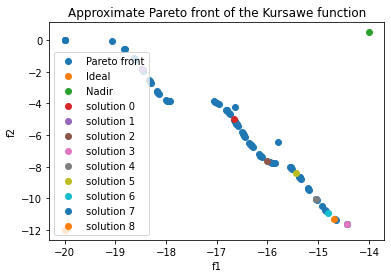

In [25]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

We REALLY like solution 6, so let us go with that:

In [26]:
response = {
    "index": 6,
    "continue": False,
    }

preferred_request.response = response


stop_request, plot_request = method.iterate(preferred_request)

We are done, let us bask in the glory of the solution found:

Final decision variables: [-1.02562883 -1.09959965 -1.09959129]


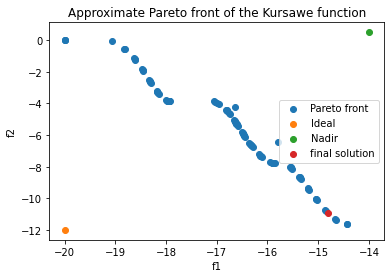

In [27]:
print(f"Final decision variables: {stop_request.content['solution']}")

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.scatter(stop_request.content["objective"][0], stop_request.content["objective"][1], label=f"final solution")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()